## Deep CNN Architecture 1


In [1]:
# As usual, a bit of setup

import numpy as np
import matplotlib.pyplot as plt
from cs231n.classifiers.cnn import *
from cs231n.data_utils import get_CIFAR10_data
from cs231n.gradient_check import eval_numerical_gradient_array, eval_numerical_gradient
from cs231n.layers import *
from cs231n.fast_layers import *
from cs231n.solver import Solver
from cs231n.classifiers.convnet2 import *
from cs231n.classifiers.convnet3 import *
from time import time

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

def rel_error(x, y):
  """ returns relative error """
  return np.max(np.abs(x - y) / (np.maximum(1e-8, np.abs(x) + np.abs(y))))


In [2]:
# Load the (preprocessed) CIFAR10 data.

data = get_CIFAR10_data()
for k, v in data.iteritems():
  print '%s: ' % k, v.shape


X_val:  (1000L, 3L, 32L, 32L)
X_train:  (49000L, 3L, 32L, 32L)
X_test:  (1000L, 3L, 32L, 32L)
y_val:  (1000L,)
y_train:  (49000L,)
y_test:  (1000L,)


In [39]:
from cs231n.classifiers.convnet3 import *

outfile = 'bestparams.npz'
npzfile = np.load(outfile)
print('npzfile.files: {}'.format(npzfile.files))
best_params = npzfile["arr_0"].item()

best_model = None
best_val = -1
results = {}
solvers = {}
times = {}

network_architectures =  {'{CONV064}x2-Pool-{CONV128}x3-Pool':([[64,64],[128,128,128]],[[3,3],[3,3,3]])
                        }
learning_rates = [2e-4*0.95**10]
regularization_strengths = [0.001]

for label, network in sorted(network_architectures.iteritems()):
    print 'CONV Network:', label
    for i in range(1):
        print 'Run number: %d '% i
        n, f = network
        version = 1
        for lr in learning_rates:
            for reg in regularization_strengths:
                print 'Learning rate: %e Reg Strength: %e '% (lr, reg)
                num_filters, filter_sizes = network
                model = DeepConvNet3(num_filters=num_filters, filter_sizes=filter_sizes, weight_scale=1e-2, 
                                     hidden_dim=500, reg=reg, verbose=False, use_batchnorm=True)
 
                model.params = best_params  # Transfer parameters from models trained for 10 epochs

                t1 = time()               
                solver = Solver(model, data,
                    num_epochs=10, batch_size=50,
                    update_rule='adam',
                    optim_config={
                      'learning_rate': lr,
                    }, lr_decay=0.95, verbose=True, print_every=20)
                solvers[(label,i,version,lr,reg)] = solver
                solver.train()
                t2 = time()

                times[(label,i,version,lr,reg)] = (t2 - t1)
                print 'Training Time: %fs' % (t2 - t1)
        
                results[(label,i,version,lr,reg)] = solver.best_val_acc
  
                if (solver.best_val_acc > best_val):
                    best_val = solver.best_val_acc
                    best_model = model
            
                version += 1

npzfile.files: ['arr_0']
CONV Network: {CONV064}x2-Pool-{CONV128}x3-Pool
Run number: 0 
Learning rate: 1.197474e-04 Reg Strength: 1.000000e-03 
(Iteration 1 / 9800) loss: 0.242890
(Epoch 0 / 10) train acc: 0.250000; val_acc: 0.230000
(Iteration 21 / 9800) loss: 0.428763
(Iteration 41 / 9800) loss: 0.216675
(Iteration 61 / 9800) loss: 0.201806
(Iteration 81 / 9800) loss: 0.232336
(Iteration 101 / 9800) loss: 0.182451
(Iteration 121 / 9800) loss: 0.173297
(Iteration 141 / 9800) loss: 0.190168
(Iteration 161 / 9800) loss: 0.279800
(Iteration 181 / 9800) loss: 0.212770
(Iteration 201 / 9800) loss: 0.209460
(Iteration 221 / 9800) loss: 0.224360
(Iteration 241 / 9800) loss: 0.206679
(Iteration 261 / 9800) loss: 0.210860
(Iteration 281 / 9800) loss: 0.212197
(Iteration 301 / 9800) loss: 0.235277
(Iteration 321 / 9800) loss: 0.187021
(Iteration 341 / 9800) loss: 0.308321
(Iteration 361 / 9800) loss: 0.201158
(Iteration 381 / 9800) loss: 0.248456
(Iteration 401 / 9800) loss: 0.217838
(Iteration

{CONV064}x2-Pool-{CONV128}x3-Pool (Version 1) lr = 1.197474e-04; reg = 1.000000e-03, val accuracy: 0.858000
best validation accuracy achieved during cross-validation: 0.858000



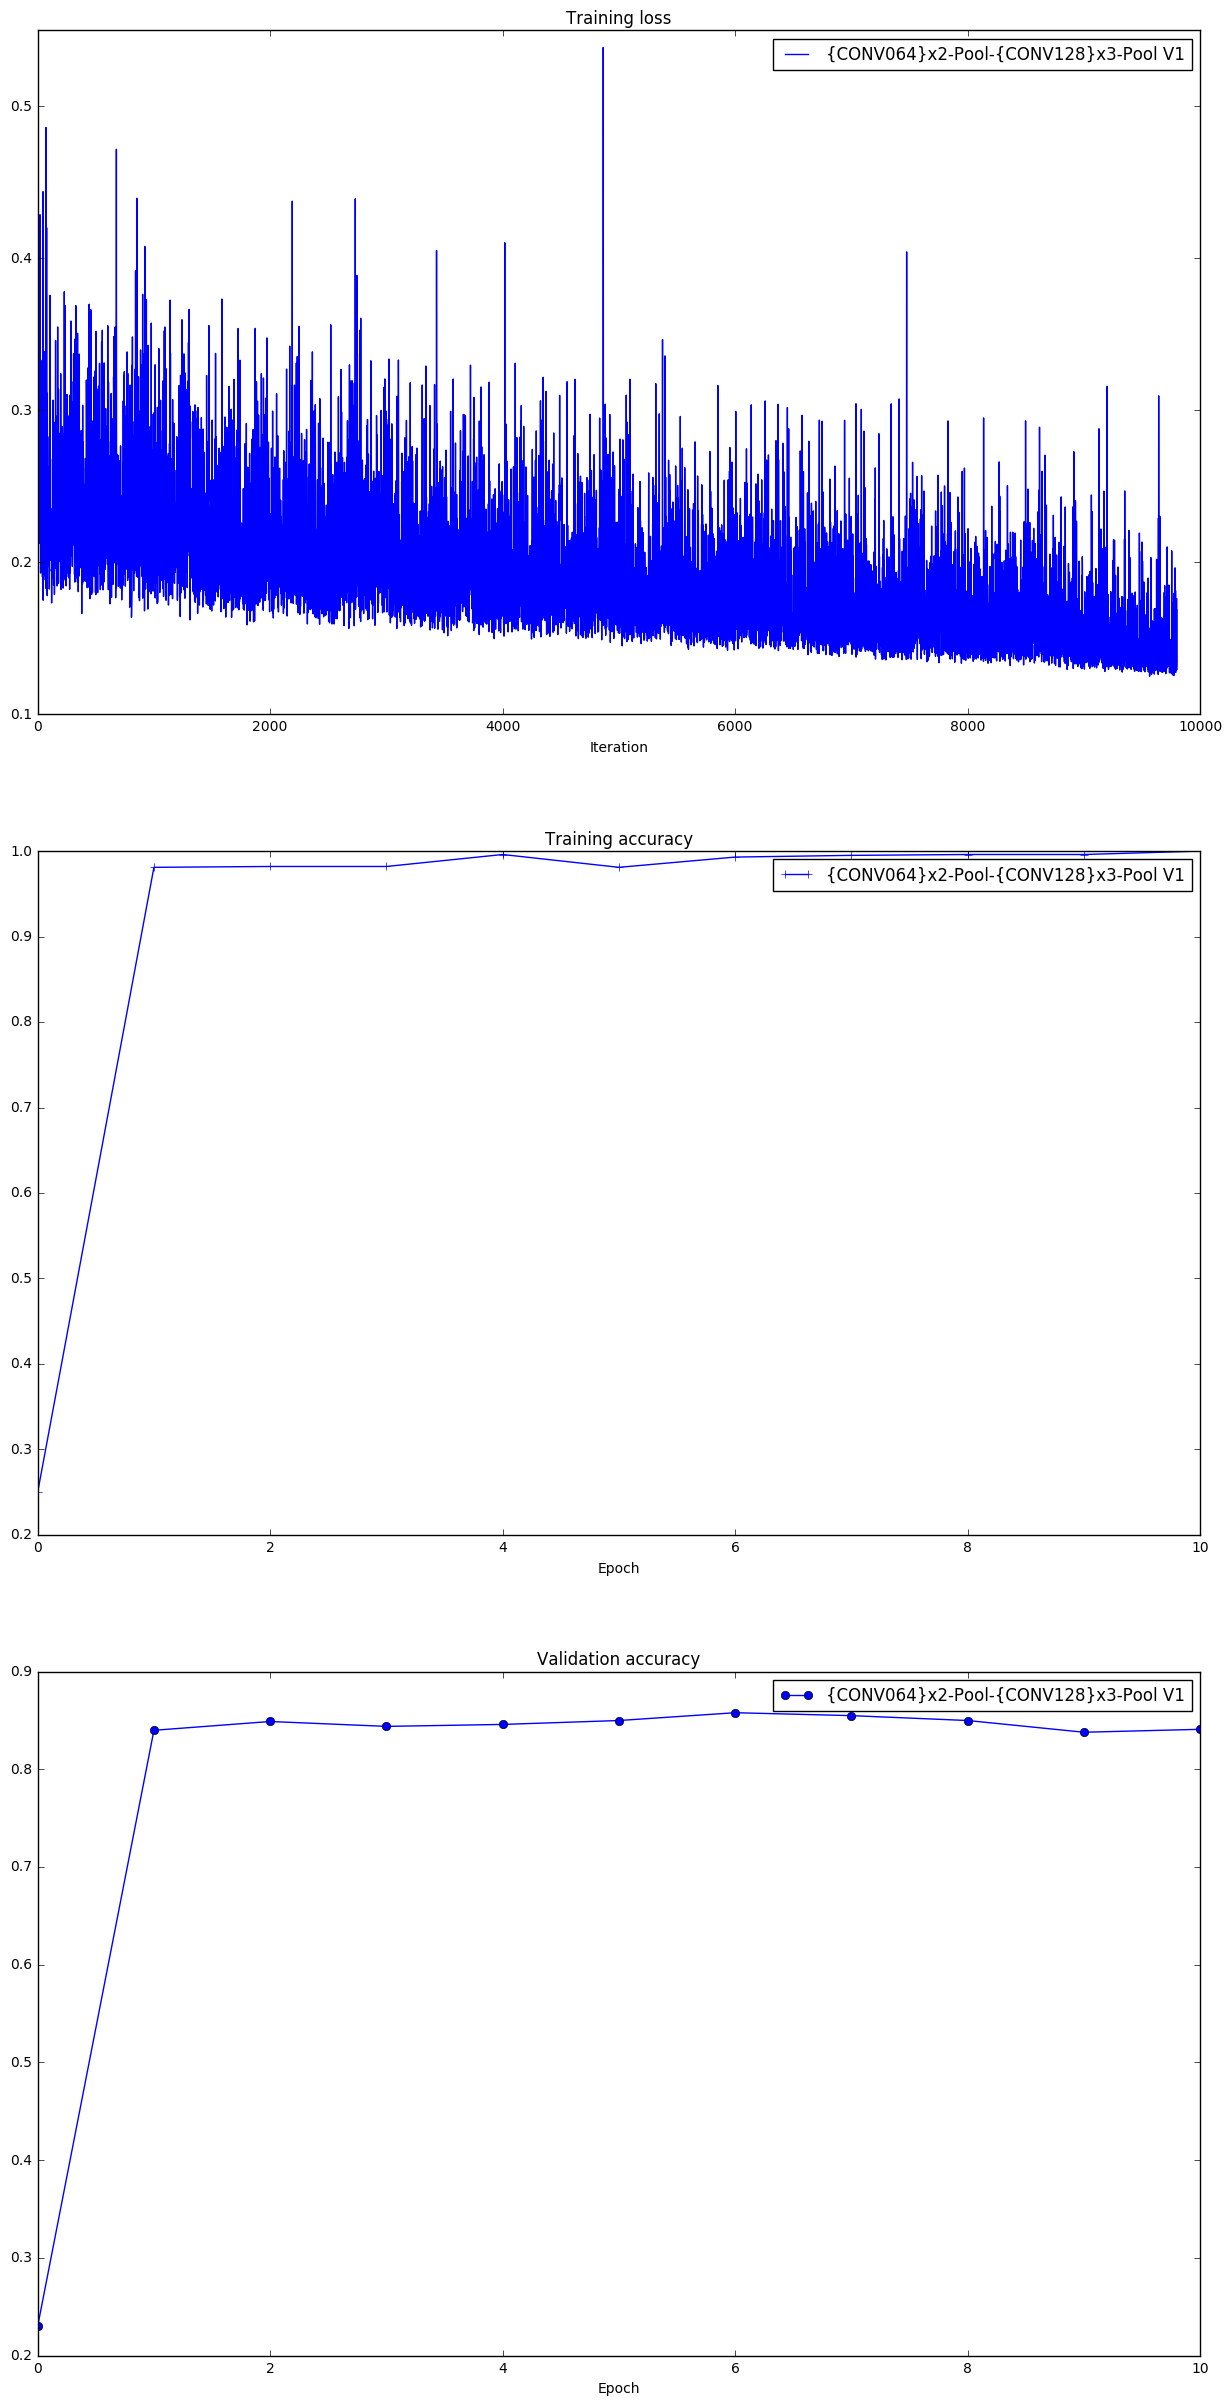

In [40]:
# Print out results.
v = 1
for param,accuracy in sorted(results.iteritems()):
    architecture, i, version, lr, reg = param
    print '%s (Version %d) lr = %e; reg = %e, val accuracy: %f' % (architecture, version, lr, reg, accuracy)
    v += 1
    
print 'best validation accuracy achieved during cross-validation: %f' % best_val

print 

plt.subplot(3, 1, 1)
plt.title('Training loss')
plt.xlabel('Iteration')

plt.subplot(3, 1, 2)
plt.title('Training accuracy')
plt.xlabel('Epoch')

plt.subplot(3, 1, 3)
plt.title('Validation accuracy')
plt.xlabel('Epoch')

for items, solver in solvers.iteritems():
  label = "%s V%d" % (items[0], items[2])
  plt.subplot(3, 1, 1)
  plt.plot(solver.loss_history, '-', label=label)
  
  plt.subplot(3, 1, 2)
  plt.plot(solver.train_acc_history, '-+', label=label)

  plt.subplot(3, 1, 3)
  plt.plot(solver.val_acc_history, '-o', label=label)
  
for i in [1, 2, 3]:
  plt.subplot(3, 1, i)
  plt.legend(loc='best', ncol=2)
plt.gcf().set_size_inches(15, 30)
plt.show()

# Ensemble of 3 Models of DeepCNN3

There is accuracy improvement from three models of the same architecture.

In [5]:
outfile = 'bestparams-1.npz'
npzfile = np.load(outfile)

params = npzfile['params'].item()
bn_params = npzfile['bn_params'].item()

# This was the model that was trained

model_1 = DeepConvNet3(num_filters=[[32,64,64],[128,128,128]], filter_sizes=[[3,3,3],[3,3,3]], weight_scale=1e-2, 
                    hidden_dim=500, verbose=False, reg = 0, use_batchnorm=True)
model_1.params = params  # Transfer parameters from pre-trained model
model_1.bn_params = bn_params  # Transfer parameters from pre-trained model

t1 = time()
score_test_1 = model_1.loss(data['X_test'])
y_test_pred = np.argmax(score_test_1, axis=1)
t2 = time()
score_val_1 = model_1.loss(data['X_val'])
y_val_pred = np.argmax(score_val_1, axis=1)

print 'Model 1: '
print 'Validation set accuracy: ', (y_val_pred == data['y_val']).mean()
print 'Test set accuracy: ', (y_test_pred == data['y_test']).mean()
print 'Testing Time: %fs' % (t2 - t1)

outfile = 'bestparams-2.npz'
npzfile = np.load(outfile)

params = npzfile['params'].item()
bn_params = npzfile['bn_params'].item()

# This was the model that was trained

model_2 = DeepConvNet3(num_filters=[[32,64,64],[128,128,128]], filter_sizes=[[3,3,3],[3,3,3]], weight_scale=1e-2, 
                    hidden_dim=500, verbose=False, reg = 0, use_batchnorm=True)
model_2.params = params  # Transfer parameters from pre-trained model
model_2.bn_params = bn_params  # Transfer parameters from pre-trained model

t1 = time()
score_test_2 = model_2.loss(data['X_test'])
y_test_pred = np.argmax(score_test_2, axis=1)
t2 = time()
score_val_2 = model_2.loss(data['X_val'])
y_val_pred = np.argmax(score_val_2, axis=1)

print 'Model 2: '
print 'Validation set accuracy: ', (y_val_pred == data['y_val']).mean()
print 'Test set accuracy: ', (y_test_pred == data['y_test']).mean()
print 'Testing Time: %fs' % (t2 - t1)


outfile = 'bestparams-4.npz'
npzfile = np.load(outfile)

params = npzfile['params'].item()
bn_params = npzfile['bn_params'].item()

# This was the model that was trained

model_3 = DeepConvNet3(num_filters=[[64,64],[128,128,128]], filter_sizes=[[3,3],[3,3,3]], weight_scale=1e-2, 
                    hidden_dim=500, verbose=False, reg = 0, use_batchnorm=True)
model_3.params = params  # Transfer parameters from pre-trained model
model_3.bn_params = bn_params  # Transfer parameters from pre-trained model

t1 = time()
score_test_3 = model_3.loss(data['X_test'])
y_test_pred = np.argmax(score_test_3, axis=1)
t2 = time()
score_val_3 = model_3.loss(data['X_val'])
y_val_pred = np.argmax(score_val_3, axis=1)

print 'Model 3: '
print 'Validation set accuracy: ', (y_val_pred == data['y_val']).mean()
print 'Test set accuracy: ', (y_test_pred == data['y_test']).mean()
print 'Testing Time: %fs' % (t2 - t1)


t1 = time()
y_test_pred = np.argmax((score_test_1+score_test_2+score_test_3)/3.0, axis=1)
t2 = time()
y_val_pred = np.argmax((score_val_1+score_val_2+score_val_3)/3.0, axis=1)

print 'Model 1+2+3 Ensemble: '
print 'Validation set accuracy: ', (y_val_pred == data['y_val']).mean()
print 'Test set accuracy: ', (y_test_pred == data['y_test']).mean()
print 'Testing Time: %fs' % (t2 - t1)



Model 1: 
Validation set accuracy:  0.811
Test set accuracy:  0.803
Testing Time: 20.348000s
Model 2: 
Validation set accuracy:  0.843
Test set accuracy:  0.837
Testing Time: 21.075000s
Model 3: 
Validation set accuracy:  0.849
Test set accuracy:  0.85
Testing Time: 16.373000s
Model 1+2+3 Ensemble: 
Validation set accuracy:  0.863
Test set accuracy:  0.861
Testing Time: 0.000000s
